# 2. Model selection and validation

In [1]:
%matplotlib inline
import warnings;warnings.filterwarnings('ignore');import matplotlib.pyplot as plt;import numpy as np;import pandas as pd;import seaborn as sns;sns.set_context("notebook", font_scale=1.4);sns.set_style("whitegrid");import imp;compomics_import = imp.load_source('compomics_import', '../compomics_import.py');from IPython.core.display import HTML;css_file = '../my.css';HTML(open(css_file, "r").read())

Model selection and validation are fundamental steps in statistical learning applications. In particular, we wish to select the model that performs optimally for **unseen external data** (data not seen during training of the model parameters). For instance, when we augment the features in a data set by polynomial features of a certain degree $d$ we need to set $d$ such that it allows for training a model that performs best on all unseen external data. Any model parameter that needs to be set by the user (such as $d$)  is known as a **hyperparameter**. Depending on the type of learning method we use, we may be interested in one or more of the following.

* How many variables should be included in the model?
* What hyperparameter values should be used in fitting the model?
* How do we best scale/normalize our data?

All of these have to be chosen so the model performs well on unseen data. But how can we know this? We don't have unseen data. Well, we can estimate the expected error rate on unseen data (known as the **generalization error**) by splitting the data into a data set for training and a data set for testing the model. Let's load a regression dataset:

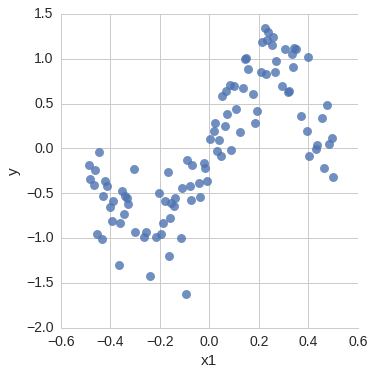

In [2]:
dataset = pd.read_csv("dataset.csv")

sns.lmplot(x="x1", y="y", data=dataset, fit_reg=False, size=5.5, scatter_kws={"s": 80})
plt.show()

We randomly select 50% of the data set that we will treat as the unseen external data, known as the **(independent) test set**. The other 50% data points will be used for training a model and is known as the **train set**.

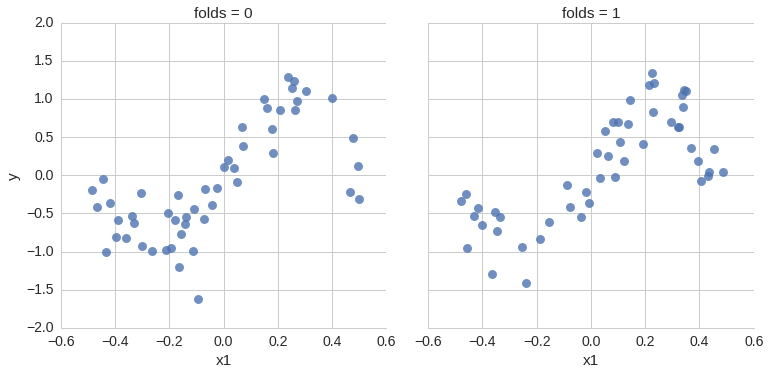

In [3]:
np.random.seed(1234)

dataset['folds'] = np.random.randint(2,size=len(dataset))

sns.lmplot(x="x1", y="y", col="folds", 
           data=dataset, fit_reg=False, size=5.5, scatter_kws={"s": 80})
plt.show()

Now we will augment the feature vectors with polynomial features of various degrees $d$ and fit a linear regression model to each train set. We evaluate the prediction performance on the corresponding test set: 

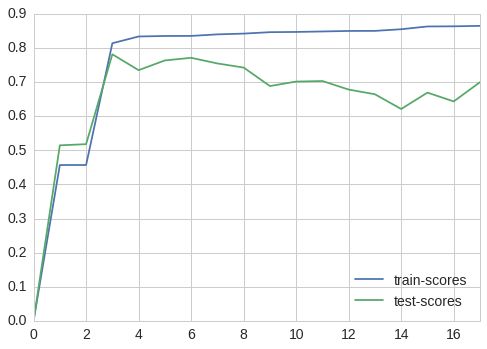

In [4]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)

X = dataset.copy()
y = X.pop('y')
folds = X.pop('folds')

train_scores = [0] #no features (d=0)
test_scores = [0]

model.fit(X[folds!=1],y[folds!=1])
train_scores.append(model.score(X[folds!=1],y[folds!=1])) # d=1
test_scores.append(model.score(X[folds==1],y[folds==1]))

for degree in range(2,18,1):
    X['x1^'+str(degree)] = X['x1']**degree
    model.fit(X[folds!=1],y[folds!=1])
    train_scores.append(model.score(X[folds!=1],y[folds!=1]))
    test_scores.append(model.score(X[folds==1],y[folds==1]))

tmp = pd.DataFrame()
tmp['train-scores'] = train_scores
tmp['test-scores'] = test_scores
tmp.plot()
plt.show()

The blue curve shows how the accuracy on the train set increases with $d$ while the green curve shows how the accuracy on the test set starts to decrease for large values of $d$. Since both the train and test set are drawn randomly from the same true function that generated the data we can conclude that $d>6$ allowed the linear regression algorithm to **fit the noise** in the augmented train set. We call this **overfitting**. For $d<3$ we can conclude that the model is not complex enough to fit the data set accurately. We call this **underfitting**.


As an extreme example of overfitting a train set we can imagine a notebook model. This model just repeats the labels of the samples that it has just seen and as such will perform perfectly for any train set. However the notebook model will fail to generalize to unseen external data and is thus useless. To find the optimal value for $d$ we could train models with different values for $d$ on the train set and select the setting that performs best on the test set. We could then report the accuracy on this test set as an estimate of the performance of the model. However, in this case the test set would not represent true unseen external data as it is used by the learning algorithm to decide on the optimal value for $d$. Which means that in this case the model can overfit the test set, knowledge about the test set can “leak” into the model and evaluation metrics no longer report a good estimate for generalization performance. 

To solve this problem, yet another part of the data set can be held out as a so-called **validation set**. In this case training proceeds on the train set and the optimal value for $d$ is selected from the validation set. A model is then trained on the union of the train and validation set using the optimal value for $d$ and the performance of this model is then tested on the test set to estimate the generalization performance. However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for actually training the model. A possible effect of this is that the performance results can depend strongly on a particular random choice of the data set splits.

A popular solution to this problem is a procedure called **cross-validation** (CV). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV, all data in the train set will be used both for learning the model and evaluating the generalization performance. In the basic approach, called **$k$-fold CV**, the train set is split into $k$ smaller sets. The following procedure is then followed for each of the $k$ “folds” $D_i$ ($i=1 \ldots k$):

1. train a model using folds $D_j$ with $j \ne i$ as training data,
2. validate the model on $D_i.$

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop and constitutes a good estimate for the generalization performance of the model given only the train set. In scikit-learn we can use the `cross_val_score()` function in the module `sklearn.cross_validation`:

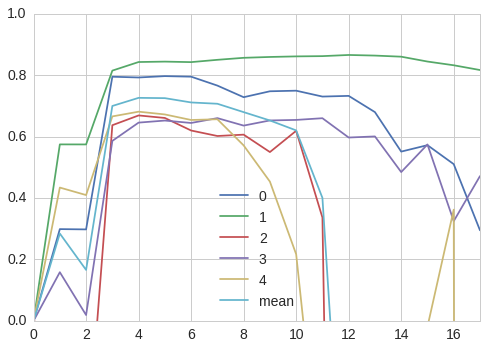

In [5]:
from sklearn.cross_validation import cross_val_score

X = dataset[dataset['folds']==0].copy()
y = X.pop('y')
folds = X.pop('folds')

scores = []
scores.append(np.zeros(5)) # no features (d=0)
scores.append(cross_val_score(model, X, y, cv=5)) # d=1
for degree in range(2,18,1):
    X['x1^'+str(degree)] = X['x1']**degree
    scores.append(cross_val_score(model, X, y, cv=5))
    
tmp = pd.DataFrame(scores)
tmp['mean'] = tmp.mean(axis=1)
tmp.plot(ylim=(0,1))
plt.show()

The average CV-score on the train set tells us that the optimal value for $d$ is somewhere between 3 and 7. We have seen that this indeed gives good generalization performance (low generalization error). We have also seen that if we had optimized $d$ on the train set then the value selected for $d$ would be much higher, leading to poor performance on unseen external data.

As we will see in the next chapters splitting a data set into train and test sets provides the means to optimize a model without overfitting. However, once the optimal model settings are found the final predictor should be trained on the full data set using these settings.

<strong>Exercises</strong>

- Load the 'diabetes.tsv' data set and standardize all the columns (including the target 'Y'). Plot the result as boxplots.

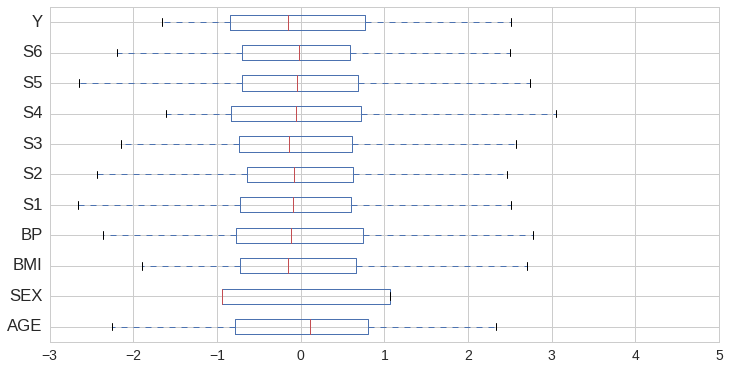

In [6]:
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("../1_regression/diabetes.tsv",sep='\t')

data_cols = data.columns.values
scaler = StandardScaler()
scaler.fit(data)
data_stand = pd.DataFrame(scaler.transform(data),columns=data_cols)
plt.figure(figsize=(12,6))
data_stand.boxplot(vert=False)
plt.show()

- Split this standardized data set into two folds at random. Then use one fold the train a linear regression model on all the features. Compute $R^2$ of this model on both the train and test set.

In [7]:
from sklearn import linear_model
from sklearn import metrics

X = data_stand.copy()
target = X.pop('Y')

folds = np.random.randint(2,size=len(X))
model = linear_model.SGDRegressor(eta0=0.001)
model.fit(data_stand[folds==0],target[folds==0])

print "R-squared on train set = %f" % metrics.r2_score(target[folds==0],model.predict(data_stand[folds==0]))
print "R-squared on test set = %f" % metrics.r2_score(target[folds==1],model.predict(data_stand[folds==1]))

R-squared on train set = 0.589847
R-squared on test set = 0.588789
